# Simulated V1 Analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
import matplotlib as mpl
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 0.5
%matplotlib inline

from scipy.io import loadmat
from tqdm import tqdm

from collections import namedtuple

import datajoint as dj
import numpy as np
import pandas as pd
from v1_likelihood import train, analysis
from v1_likelihood.analysis import LikelihoodStats
from v1_likelihood.utils import bin_loc, binned_group, binned_stats
from itertools import count, product
from collections import OrderedDict
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.stats import ttest_rel, wilcoxon, ttest_1samp, norm
from matplotlib import patches, transforms
from matplotlib.patches import ConnectionPatch

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Connecting eywalker@10.28.0.34:3306


In [2]:
def significance_indicator(p):
    if p < 0.005:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return None

In [3]:
cd_dataset = dj.create_virtual_module('cd_dataset', 'edgar_cd_dataset')
class_discrimination = dj.create_virtual_module('class_discrimination', 'edgar_class_discrimination')
cd_lc = dj.create_virtual_module('cd_lc', 'edgar_cd_lc')
cd_dlset = dj.create_virtual_module('cd_dlset', 'edgar_cd_dlset');
ephys = dj.create_virtual_module('ephys', 'ephys')
stimulation = dj.create_virtual_module('stimulation', 'stimulation')
cd_sim = dj.create_virtual_module('cd_sim', 'edgar_cd_sim')

In [4]:
def add_subplots(*args, fig=None):
    if fig is None:
        fig = plt.gcf()
    return [fig.add_subplot(gs) for gs in args]

In [5]:
from collections import namedtuple

Aggregate = namedtuple('Aggregate', ['resp_a', 'model_correct', 'logl', 'presp_a', 'subj_resp', 'ori'])
def sim_aggr_model_perf(key, lc_id=32, decoder_id=4, lc_shuffle_id=0, **kwargs):
    restr = dict(lc_id=lc_id, decoder_id=decoder_id, lc_shuffle_id=lc_shuffle_id, **kwargs)
    data = (cd_dlset.CVSet.Member * cd_sim.LCModelFits & key & restr).fetch()
    aggr = {}
    ordering = np.concatenate(data['test_indices'], axis=1)
    pos = np.argsort(ordering.squeeze())
    # reorder trials accordings to indices
    orientation = np.concatenate()
    model_choice = np.concatenate(data['model_choice'])[pos].squeeze()
    model_correct = np.concatenate(data['model_correct'])[pos].squeeze()
    subj_resp = np.concatenate(data['subj_choice'])[pos].squeeze()
    logl = np.concatenate(data['lc_test_logl'])[pos].squeeze()
    presp_a = np.exp(logl)
    presp_a[model_choice != model_correct] = 1 - presp_a[model_choice != model_correct]
    return Aggregate(model_choice, model_correct, logl, presp_a, subj_resp, orientation)

In [6]:
def get_sim_summary(restr=None, subject=None, model=32, decoder=4, shuffle=0, **kwargs):
    if restr is None:
        restr = {}
    if subject is not None:
        subj = 'subject_id = {}'.format(subject)
    else:
        subj = {}
    target = (cd_dlset.CVSet * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup * class_discrimination.CleanSpikeCountSet & restr & subj)
    cvset = target.fetch('KEY', order_by=','.join(target.primary_key))

    cond = dict(lc_id=model, decoder_id=decoder, lc_shuffle_id=shuffle, **kwargs)
    contrasts = np.array([float(c['dataset_contrast']) for c in cvset])

    list_model_resp_A = []
    list_monkey_resp_A = []
    list_test_logl = []
    list_correct_resp = []
    list_cont_vals = []
    list_oris = []
    list_n_trials = []
    
    for i, c in enumerate(cvset):
        data = (cd_sim.LCModelFits & c & cond).fetch(order_by='cv_n')
        test_logl = np.concatenate(data['lc_test_logl'])
        n_trials = len(test_logl)
        list_cont_vals.append([float(c['dataset_contrast'])] * n_trials)
        list_oris.append(np.concatenate(data['orientation'], axis=1).squeeze())
        list_n_trials.append(n_trials)
        list_test_logl.append(test_logl)
        model_resp = np.exp(test_logl)
        model_choice = [d.squeeze() for d in data['model_choice']]
        model_correct = [d.squeeze() for d in data['model_correct']]
        model_resp_A = np.concatenate(model_choice)
        correct_resp = np.concatenate(model_correct)
        list_correct_resp.append(correct_resp)
        monkey_resp_A = (model_resp_A == correct_resp)
        list_monkey_resp_A.append(monkey_resp_A)
        model_resp_A = model_resp.copy()
        model_resp_A[~monkey_resp_A] = 1 - model_resp_A[~monkey_resp_A]
        list_model_resp_A.append(model_resp_A)

    summary = {}
    summary['contrast'] = contrasts
    summary['correct_resp'] = list_correct_resp
    summary['model_resp_A'] = list_model_resp_A
    summary['monkey_resp_A'] = list_monkey_resp_A
    summary['test_logl'] = list_test_logl
    summary['n_trials'] = list_n_trials
    summary['cont_vals'] = list_cont_vals
    summary['orientation'] = list_oris
    
    return summary

## Configure plot RC

In [7]:
# make font exportable
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.0
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 2.0
mpl.rcParams['ytick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

mpl.rcParams['xtick.minor.size'] = 1.0
mpl.rcParams['ytick.minor.size'] = 1.0

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['font.size'] = 6.0
mpl.rcParams['font.sans-serif'] = ['Liberation Sans']



tom_color = np.array([1, 1, 1]) * 0
leo_color = np.array([1, 1, 1]) * 0.5
tom_marker = '^'
leo_marker = 's'
cp = sns.color_palette("RdBu_r")

c1_color = cp[-1]
c2_color = cp[0]

# Extended Data Figure 3 - Model comparison

Get data for both kinds of models and under both shuffled and non-shuffled conditions

In [60]:
decoder_id = 4
sim_seed = 529
tom32 = get_sim_summary(subject=21, model=32, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
tom32s = get_sim_summary(subject=21, model=32, decoder=decoder_id, shuffle=1, sim_seed=sim_seed)
leo32 = get_sim_summary(subject=3, model=32, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
leo32s = get_sim_summary(subject=3, model=32, decoder=decoder_id, shuffle=1, sim_seed=sim_seed)
tom38 = get_sim_summary(subject=21, model=38, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
tom38s = get_sim_summary(subject=21, model=38, decoder=decoder_id, shuffle=1, sim_seed=sim_seed)
leo38 = get_sim_summary(subject=3, model=38, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
leo38s = get_sim_summary(subject=3, model=38, decoder=decoder_id, shuffle=1, sim_seed=sim_seed)

In [109]:
decoder_id = 4
all_results = []
all_bar_stats = []
all_bar_results = []
seeds = cd_sim.SimulationSeed.fetch('sim_seed')
for sim_seed in tqdm(seeds):
    tom32 = get_sim_summary(subject=21, model=32, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
    tom32s = get_sim_summary(subject=21, model=32, decoder=decoder_id, shuffle=1, sim_seed=sim_seed)
    leo32 = get_sim_summary(subject=3, model=32, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
    leo32s = get_sim_summary(subject=3, model=32, decoder=decoder_id, shuffle=1, sim_seed=sim_seed)
    tom38 = get_sim_summary(subject=21, model=38, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
    tom38s = get_sim_summary(subject=21, model=38, decoder=decoder_id, shuffle=1, sim_seed=sim_seed)
    leo38 = get_sim_summary(subject=3, model=38, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
    leo38s = get_sim_summary(subject=3, model=38, decoder=decoder_id, shuffle=1, sim_seed=sim_seed)

    summary_pairs = [(leo32, leo38), (leo32s, leo38s), (tom32, tom38),  (tom32s, tom38s),]
    results = []
    for m1, m2 in summary_pairs:
        contrasts = np.concatenate(m1['cont_vals']).squeeze()
        m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
        m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
        delta_logl = m1_test_logl - m2_test_logl
        cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
        stats = binned_stats(contrasts, delta_logl, cont_edges)
        results.append(stats)
    all_results.append(results)
    
    summary_pairs = [(leo32, leo38, leo32s, leo38s), (tom32, tom38, tom32s, tom38s),]
   

    bar_results = []
    bar_stats = []
    for m1, m1b, m2, m2b in summary_pairs:
        contrasts = np.concatenate(m1['cont_vals']).squeeze()
        m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
        m1b_test_logl = np.concatenate(m1b['test_logl']).squeeze()
        m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
        m2b_test_logl = np.concatenate(m2b['test_logl']).squeeze()
        delta1_logl = m1_test_logl - m1b_test_logl
        delta2_logl = m2_test_logl - m2b_test_logl
        delta12_logl = m1_test_logl - m2_test_logl

        res1 = ttest_1samp(delta1_logl, 0)
        res2 = ttest_1samp(delta2_logl, 0)
        res12 = ttest_1samp(delta12_logl, 0)
        
        mu1 = delta1_logl.mean()
        mu2 = delta2_logl.mean()
        
        bar_results.append((mu1, mu2))
        bar_stats.append((res1, res2, res12))
        
    all_bar_results.append(bar_results)
    all_bar_stats.append(bar_stats)    

100%|██████████| 5/5 [02:17<00:00, 27.43s/it]


In [115]:
summaries = []

for vals in zip(*all_results):
    mu_stack = np.stack([s.mu for s in vals])
    mu = mu_stack.mean(axis=0)
    sigma = mu_stack.std(axis=0, ddof=1)
    binc_all = np.stack([s.binc for s in vals])
    binc = binc_all[0]
    np.all((binc_all - binc)==0)
    summary = {
        'mu': mu,
        'sigma': sigma,
        'binc': binc
    }
    summaries.append(summary)
    
    
bar_summaries = []
bar_stats_summaries = []

for vals in zip(*all_bar_results):
    mu_stack = np.stack(vals)
    mu = mu_stack.mean(axis=0)
    sigma = mu_stack.std(axis=0, ddof=1)
    summary = {
        'mu': mu,
        'sigma': sigma,
    }
    bar_summaries.append(summary)

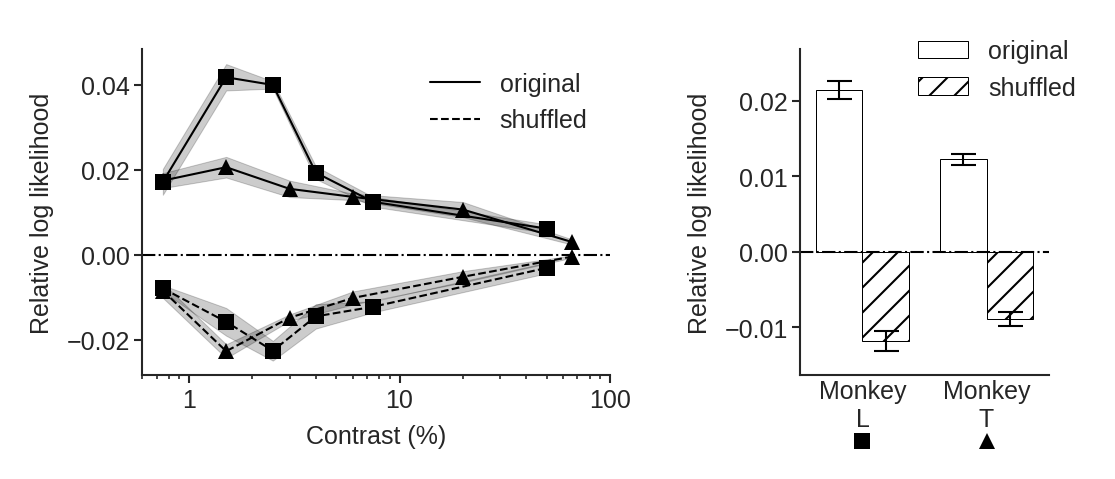

In [116]:
fs = 6.0
fs_inset = 5.0
offset = 0
trim = False
marker_size=4
pad = 1
labelpad=3

sample_ori = 10
sample_shade = np.array([1, 1, 1]) * 0.2

#pos = (likelihood_data['orientationBin'] -270 == sample_ori).squeeze()
#decode_ori = (likelihood_data['decodeOri'] - 270).squeeze()
#L = likelihood_data['oldLikelihood'][:, pos].T
#peaks = likelihood_data['originalPeaks'][0, pos].squeeze()

capsize=3

original_color = 'k'#xkcd:turquoise'
shuffled_color = 'k'#xkcd:light orange'
original_style = '-'
shuffled_style = '--'


# get likelihood data

fig = plt.figure(figsize=(7.2, 3.6), dpi=300)
gs = gridspec.GridSpec(2, 16, wspace=2.8, hspace=0.5)



gs_delta_logl = gs[0, :5]
gs_bar = gs[0, 6:9]
gs_shuffling = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1, :9], wspace=0.4)


gs_lwidth_original = gs[0, 10:]
gs_lwidth_shuffled = gs[1, 10:]



########## Delta log likelihood vs contrast relative to fixed-uncertainty model ##############
ax, = add_subplots(gs_delta_logl)
summary_pairs = [(leo32, leo38), (leo32s, leo38s), (tom32, tom38),  (tom32s, tom38s),]
markers = [leo_marker, leo_marker, tom_marker, tom_marker]
marker_sizes = [marker_size] * 4
colors = [original_color, shuffled_color] * 2
linestyles=[original_style, shuffled_style, original_style, shuffled_style]


for summary, marker, ms, color, ls in zip(summaries, markers, marker_sizes, colors, linestyles):
    binc = summary['binc']
    mu = summary['mu']
    sigma = summary['sigma']
    ax.fill_between(binc, mu-sigma, mu+sigma, alpha=0.2, color=color)
    ax.plot(binc, mu, marker=marker, ms=ms, color=color, linestyle=ls)


ax.axhline(0, linestyle='-.', color='k')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
tx=ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
ax.set_ylim(ax.get_ylim())
x = [0, 1]
y = [1, 1]
ax.plot(x, y, '-k', label='original')
ax.plot(x, y, '--k', label='shuffled')
ax.legend(fontsize=fs)

ylim = np.array(ax.get_ylim()) / 1.5


## Delta log likelihood bar plot relative to non-Bayesian
ax, = add_subplots(gs_bar)
summary_pairs = [(leo32, leo38, leo32s, leo38s), (tom32, tom38, tom32s, tom38s),]
markers = [leo_marker, tom_marker]
colors = [(original_color, shuffled_color), (original_color, shuffled_color)]
group_labels = ['Monkey\nL', 'Monkey\nT']

bar_spacing = 0.8
bar_width = 0.3
bar_centers = np.arange(len(summary_pairs)) * bar_spacing

for i, bc, bar_summary, marker, (c1, c2) in zip(count(), bar_centers, bar_summaries, markers, colors):
    
    mu1, mu2 = bar_summary['mu']
    sigma1, sigma2 = bar_summary['sigma']
    
    textshift = 0.0005
    star_offset = 2e-3

    
    barc = bc - bar_width/2
    lbl = 'original' if i==0 else None
    ax.bar(barc, mu1, bar_width, color=c1, facecolor='w', edgecolor=c1, label=lbl)
    ax.errorbar(barc, mu1, sigma1, fmt='none', capsize=capsize, capthick=0.5, color=c1,)
    
    
    barc = bc + bar_width/2
    ax.errorbar(barc, mu2, sigma2, fmt='none', capsize=capsize, capthick=0.5, color=c2,)
    lbl = 'shuffled' if i==0 else None
    bars = ax.bar(barc, mu2, bar_width, edgecolor=c2, facecolor='w', label=lbl)
    bars[0].set_hatch('////')
    
    
    # plot the marker below the xlabel
    trans = transforms.blended_transform_factory(
        ax.transData, ax.transAxes)
    ax.plot(bc, -0.2, transform=trans, color='k', marker=marker, ms=4, clip_on=False)
ax.axhline(0, linestyle='-.', color='k')

    
ax.set_xticks(bar_centers)
ax.set_xticklabels(group_labels)
ax.set_xlim([bar_centers[0] - bar_spacing/2, bar_centers[-1] + bar_spacing/2])
ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
ax.set_ylim(np.array(ax.get_ylim()) * 1.1)#[-0.015, 0.02])
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
ax.tick_params(axis='x', length=0)
ax.legend(fontsize=fs, bbox_transform=ax.transAxes, bbox_to_anchor=[0, 0, 1.2, 1.1], loc='upper right')

fig.savefig('figures/ext_fig03.pdf')
fig.savefig('figures/ext_fig03.png', dpi=300)

# Figure Extra - Model performance

Get data for each subject and for two models. 

* model 32 - Full likelihood model
* model 38 - Fixed uncertainty model

In [117]:
decoder_id = 4
sim_seed = 529
tom32 = get_sim_summary(subject=21, model=32, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
leo32 = get_sim_summary(subject=3, model=32, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
tom38 = get_sim_summary(subject=21, model=38, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)
leo38 = get_sim_summary(subject=3, model=38, decoder=decoder_id, shuffle=0, sim_seed=sim_seed)


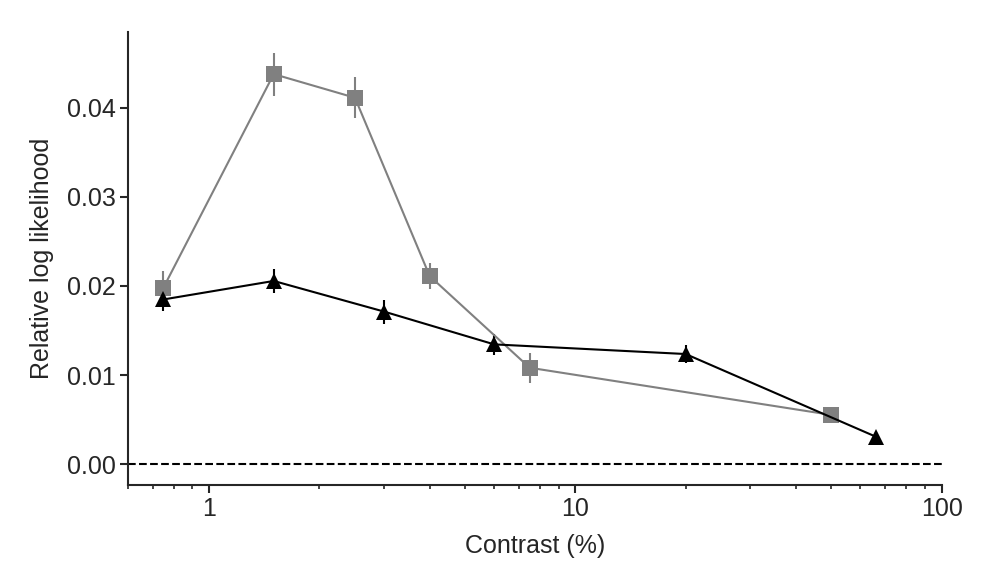

In [118]:
marker_size=4
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
wspace=0.2
hspace=0.2

fig = plt.figure(figsize=(3.5, 2), dpi=300)
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.5)
gs_bar = gridspec.GridSpec(1, 1, left=0.55, right=0.85, bottom=0.55, top=0.85)

gs_delta_logl = gs[0, 0]
gs_bar_delta = gs_bar[0, 0]


######## Delta log likelihood vs contrast ########
ax, = add_subplots(gs_delta_logl)
summary_pairs = [(leo32, leo38), (tom32, tom38)]
markers = [leo_marker, '^']
linestyles=['-', '-']
colors = [leo_color, tom_color]

deltas = []
for (m1, m2), marker, color, ls in zip(summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    deltas.append(delta_logl)
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, delta_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(0, linestyle='--', color='k')
ax.set_xscale('log')
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)

# ###### Delta log likelihood bar plot #######
# ax, = add_subplots(gs_bar_delta)
# summary_pairs = [(leo32, leo38), (tom32, tom38),]
# markers = [leo_marker, tom_marker]
# colors = [leo_color, tom_color]
# group_labels = ['Monkey L', 'Monkey T']

# for i, (m1, m2), marker, color, ls in zip(count(), summary_pairs, markers, colors, linestyles):
#     contrasts = np.concatenate(m1['cont_vals']).squeeze()
#     m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
#     m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
#     delta_logl = m1_test_logl - m2_test_logl
#     res = ttest_rel(m1_test_logl, m2_test_logl)
#     mu = delta_logl.mean()
#     ax.bar(i, mu, 0.5, color=color)
#     sem = delta_logl.std() / np.sqrt(len(delta_logl))
#     ax.errorbar(i, mu, sem, fmt='none', capsize=5, capthick=0.5, color=color,)
#     # plot the markers
#     ax.plot(i, -0.003, marker=marker, ms=marker_size, color=color, clip_on=False)
#     label = significance_indicator(res.pvalue)
#     if label:
#         ax.text(i, mu + 1.5*sem, label, horizontalalignment='center', verticalalignment='center', fontsize=fs)
        
# ax.set_xticks([0, 1])
# ax.set_xticklabels(group_labels)
# ax.set_xlim([-0.5, 1.5])

# ax.set_ylim([0, 0.013])
# ax.set_yticks([0, 0.005, 0.01])
# ax.set_yticklabels(['0', '0.005', '0.01'])
# ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
# sns.despine(ax=ax, trim=trim, offset=offset)
# ax.tick_params(labelsize=fs, pad=pad)
# ax.tick_params(axis='x', length=0) # just suppress ticks


#fig.savefig('figures/fig04x.pdf')
#fig.savefig('figures/fig04x.png', dpi=200)
#ax.minorticks_off()

[76.52498604 76.09074368 81.07065348 86.23221512 89.74581248 89.00271037]
[76.73233696 70.755916   80.0949534  83.50386489 86.0354805  85.21157827]
[75.24078727 74.95644768 80.18246122 85.62850803 89.31237941 88.89813688]
[75.23097826 67.42117049 77.67422777 82.40918636 85.47576131 85.02154807]


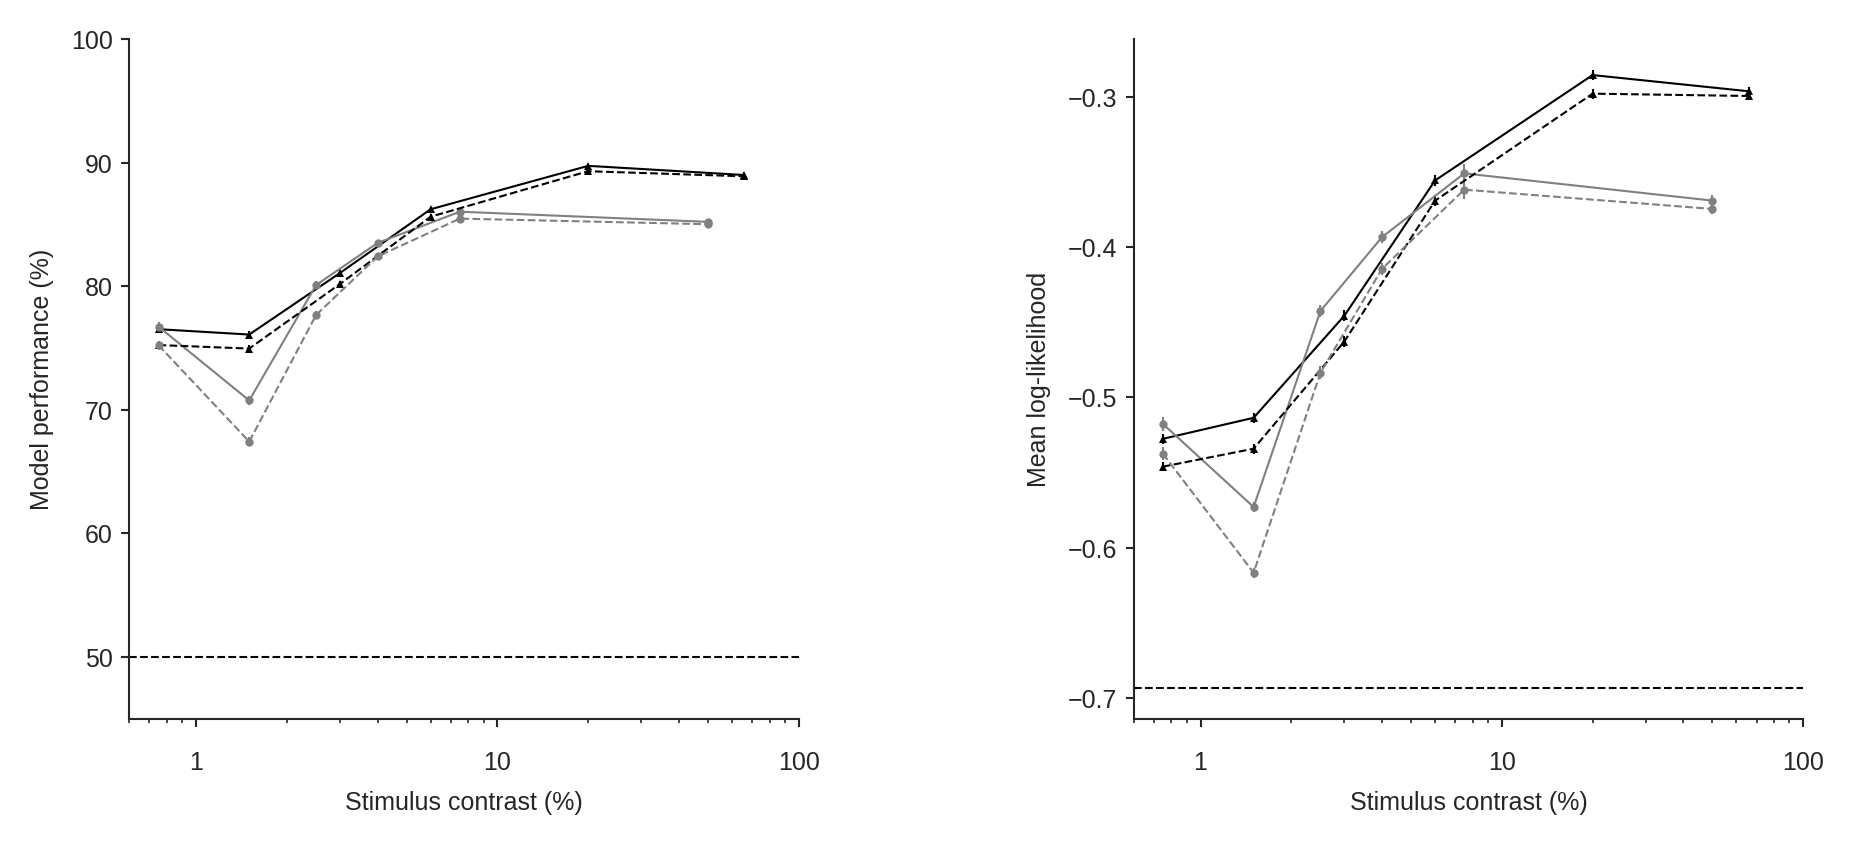

In [119]:
fs = 6.0
offset = 0
trim = False
marker_size=2
pad = 1
labelpad=3
wspace=0.2
hspace=0.2

fig = plt.figure(figsize=(7.2, 3), dpi=300)
gs = gridspec.GridSpec(1, 2, wspace=0.5, hspace=0.5)

gs_correct = gs[0, 0]
gs_mean_logl = gs[0, 1]


################ Performance vs contrast #####################
ax, = add_subplots(gs_correct)
summary_sets = [tom32, leo32, tom38, leo38]
markers = ['^', 'o'] * 2
linestyles=['-', '-', '--', '--']
colors = [tom_color, leo_color] * 2

for summary_set, marker, color, ls in zip(summary_sets, markers, colors, linestyles):
    contrasts = np.concatenate(summary_set['cont_vals']).squeeze()
    correct_resp = np.concatenate(summary_set['correct_resp']).squeeze() * 100
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, correct_resp, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)
    print(stats.mu)

ax.axhline(50, linestyle='--', color='k')

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_ylim([45, 100])
ax.set_yticks([50, 60, 70, 80, 90, 100])
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Model performance (%)', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
#ax.minorticks_off()

########## Mean log likelihood vs contrast #####################
ax, = add_subplots(gs_mean_logl)
summary_sets = [tom32, leo32, tom38, leo38]
markers = ['^', 'o'] * 2
linestyles=['-', '-', '--', '--']
colors = [tom_color, leo_color] * 2

for summary_set, marker, color, ls in zip(summary_sets, markers, colors, linestyles):
    contrasts = np.concatenate(summary_set['cont_vals']).squeeze()
    test_logl = np.concatenate(summary_set['test_logl']).squeeze() 
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, test_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(np.log(0.5), linestyle='--', color='k')

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Mean log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)


#fig.savefig('figures/ext_sim_fig01.pdf')
#ax.minorticks_off()

In [120]:
ren

NameError: name 'ren' is not defined

In [77]:
rel = cd_lc.LCModelFits().proj(real_mu_logl='lc_test_mu_logl')

In [84]:
cd_sim.LCModelFits()

sim_seed simulation seed,lc_id unique id for the likelihood classifier,dec_trainset_owner name of the table that owns this dataset,dec_trainset_hash SHA-1 hash for the primary key of the target data entry,decoder_id unique id for the decoder model,lc_shuffle_id unique id for shuffle param,cv_seed seed for rng,cv_n n-way cross validation,cv_index index into the N-way CV,source_lc_id unique id for the likelihood classifier,source_shuffle_id unique id for shuffle param,lc_test_mu_logl mean loglikelihood,lc_test_logl logl values for all trials,lc_testset_size size of the testset,src_test_mu_logl source score,src_test_logl all scores,model_choice binary readout of a trial from the model,model_correct indicates whether model choice was correct,subj_choice subject choice,prop_correct proportion of correct trials,orientation orientation
166,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,4,0,498365,10,1,32,0,-0.0383243,=BLOB=,21,-0.0744541,=BLOB=,=BLOB=,=BLOB=,=BLOB=,1.0,=BLOB=
166,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,4,0,498365,10,2,32,0,-0.0155802,=BLOB=,21,-0.0350147,=BLOB=,=BLOB=,=BLOB=,=BLOB=,1.0,=BLOB=
166,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,4,0,498365,10,3,32,0,-0.0819773,=BLOB=,21,-0.0926913,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.952381,=BLOB=
166,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,4,0,498365,10,4,32,0,-0.0273301,=BLOB=,21,-0.0395819,=BLOB=,=BLOB=,=BLOB=,=BLOB=,1.0,=BLOB=
166,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,4,0,498365,10,5,32,0,-0.0356357,=BLOB=,21,-0.0451848,=BLOB=,=BLOB=,=BLOB=,=BLOB=,1.0,=BLOB=
166,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,4,0,498365,10,6,32,0,-0.612332,=BLOB=,20,-0.377345,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.85,=BLOB=
166,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,4,0,498365,10,7,32,0,-0.0552683,=BLOB=,21,-0.0610198,=BLOB=,=BLOB=,=BLOB=,=BLOB=,1.0,=BLOB=


In [104]:
rel = (cd_dlset.LCModelFits() & 'decoder_id=4' & 'lc_shuffle_id=0' & 'lc_id = 32').proj(source_lc_id='lc_id', source_shuffle_id='lc_shuffle_id', real_test_mu_logl='lc_test_mu_logl')

In [105]:
a, b = (cd_sim.LCModelFits() * rel & 'decoder_id = 4' & 'lc_id = 32' & 'sim_seed = 166' & 'lc_shuffle_id = 0').fetch('lc_test_mu_logl', 'real_test_mu_logl')

In [107]:
(a - b).mean()

-0.0008668949153846151

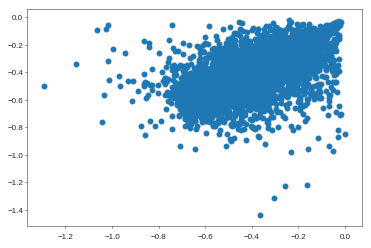

In [108]:
plt.scatter(a, b)

In [70]:
cd_lc.TrainedLC()

dec_trainset_owner name of the table that owns this dataset,dec_trainset_hash SHA-1 hash for the primary key of the target data entry,decoder_id unique id for the decoder model,lc_id unique id for the likelihood classifier,lc_trainset_owner name of the table that owns this dataset,lc_trainset_hash SHA-1 hash for the primary key of the target data entry,lc_class class name for the likelihood classifier,lc_label descriptor for the model,lc_trained_config structure for configuring the model,lc_train_mu_logl mean log likelihood,lc_trainset_size size of the trainset
cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,1,1,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,ClassifierModel.LikelihoodClassifier.PointPSLLC,Peak - Gaussian,=BLOB=,-0.3989779670684084,209
cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,1,1,cd_dataset.CleanCVTrainSets,2cf8b2d0743296e20d169601390375797c75a4e7,ClassifierModel.LikelihoodClassifier.PointPSLLC,Peak - Gaussian,=BLOB=,-0.4114754858264429,188
cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,1,1,cd_dataset.CleanCVTrainSets,504038d5b6cab42b99c993ccf55347a1d1b2e3e3,ClassifierModel.LikelihoodClassifier.PointPSLLC,Peak - Gaussian,=BLOB=,-0.3840767696837546,188
cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,1,1,cd_dataset.CleanCVTrainSets,55f05476d36c9ff357f11916e8fa0add38f814bb,ClassifierModel.LikelihoodClassifier.PointPSLLC,Peak - Gaussian,=BLOB=,-0.4063439410694436,188
cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,1,1,cd_dataset.CleanCVTrainSets,5e8f3a9717d702905aa5c41e262e636c4b9aedba,ClassifierModel.LikelihoodClassifier.PointPSLLC,Peak - Gaussian,=BLOB=,-0.4268794789796738,188
cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,1,1,cd_dataset.CleanCVTrainSets,6ce1d1d4e865c7ef852f4a8b548e620a95e71eee,ClassifierModel.LikelihoodClassifier.PointPSLLC,Peak - Gaussian,=BLOB=,-0.3552931573621622,188
cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,1,1,cd_dataset.CleanCVTrainSets,910bc8a27d3521b0bd92d2b4c063e15e8b7cb081,ClassifierModel.LikelihoodClassifier.PointPSLLC,Peak - Gaussian,=BLOB=,-0.4073454119933804,188


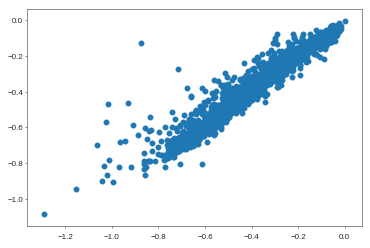

In [67]:
plt.scatter(a, b)

In [31]:
tom32.keys()

dict_keys(['n_trials', 'cont_vals', 'contrast', 'model_resp_A', 'test_logl', 'orientation', 'monkey_resp_A', 'correct_resp'])